# Importing libraries, Building the data loader

In [1]:
## import libraries for model
from os import listdir
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from keras import backend as K #changed from tensorflow.keras
# from keras.optimizers import Adam
# import keras_tuner as kt
from keras.callbacks import Callback,ModelCheckpoint
# from keras_tuner import HyperModel, HyperParameters, Hyperband
from matplotlib import pyplot as plt
from functools import partial
from SL_tumorCNN_custom_lib import batch_maker, f1_score_3ch #, make_pred_patches
import numpy as np
# import json
import sys
from mealpy import MixedSetVar, PSO
from mealpy.utils import io
import gc
# from keras import mixed_precision

# # Set the global policy to mixed precision
# mixed_precision.set_global_policy('mixed_float16')
metric = f1_score_3ch


# https://youtu.be/ScdCQqLtnis

## initialize variables and define file list

batch_size = 2
num_classes = 4
num_in_ch = 4
total_epochs_elapsed = 0
learning_rate = 1e-4
parentdir =  "D:\\patches_train_BRATS" #D for PC, F for laptop
modeldir = 'C:\\Users\\user\\Documents\\Python Scripts\\Tumor classifcation and Segmentation Neural Network project\\'
foldername = "pickles_1mm"

## define file list
#there should be 3200 images if 1.0mm
file_list = listdir(f"{parentdir}\\{foldername}") 
file_list.sort()

blocks = [file_list[i:i + 8] for i in range(0, len(file_list), 8)] #block size = 8 for 1.0mm
random.Random(4).shuffle(blocks)
# Flatten the shuffled blocks back into a single list
shuffled_file_list = [item for block in blocks for item in block]

del(blocks, file_list)

In [2]:
from numba import cuda


In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

In [3]:
from tensorflow.python.framework import config
config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=9408807)]) 

In [2]:

try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass


In [ ]:
flag = 0
 
# using set() + len()
# to check all unique list elements
test_list = shuffled_file_list
flag = len(set(test_list)) == len(test_list)
 
 
# printing result
if(flag):
    print("List contains all unique elements")
else:
    print("List contains does not contains all unique elements")

del(flag,test_list)

In [4]:
def get_random_subsample(train_file_list, seed=42):
    # Set the seed for reproducibility
    random.seed(seed)
    half_size = len(train_file_list) // 4
    subsample_list = random.sample(train_file_list, half_size)
    return subsample_list

val_ratio = 0.2
#define training and validation sets

val_size = round(len(shuffled_file_list)*val_ratio)
train_file_list = shuffled_file_list[val_size:]
val_file_list = shuffled_file_list[:val_size]

train_file_list = get_random_subsample(train_file_list)
val_file_list = get_random_subsample(val_file_list)
random.Random(4).shuffle(train_file_list)
random.Random(4).shuffle(val_file_list)

steps_per_epoch = len(train_file_list)//batch_size
val_steps_per_epoch = len(val_file_list)//batch_size

## generate batch size of up to 5 on Colab
#dimensions are (batch size, img size, num of channels)
train_data = batch_maker(batch_size,train_file_list,parentdir,foldername,num_classes,num_in_ch,0.5)
val_data = batch_maker(batch_size,val_file_list,parentdir,foldername,num_classes,num_in_ch)

print(f'first 5: {train_file_list[:7]}')
#del(train_file_list,val_file_list)


first 5: ['BRATS_00100_patch_0_0_0.pkl', 'BRATS_00477_patch_1_0_1.pkl', 'BRATS_00511_patch_1_0_0.pkl', 'BRATS_00563_patch_0_1_0.pkl', 'BRATS_00628_patch_1_0_1.pkl', 'BRATS_00339_patch_1_1_0.pkl', 'BRATS_00178_patch_1_1_0.pkl']


first 5: ['BRATS_00100_patch_0_0_0.pkl', 'BRATS_00477_patch_1_0_1.pkl', 'BRATS_00511_patch_1_0_0.pkl', 'BRATS_00563_patch_0_1_0.pkl', 'BRATS_00628_patch_1_0_1.pkl', 'BRATS_00339_patch_1_1_0.pkl', 'BRATS_00178_patch_1_1_0.pkl']


### Batch maker test

In [5]:
from SL_tumorCNN_custom_lib import batch_maker_debug
train_data = batch_maker_debug(batch_size,train_file_list,parentdir,foldername,num_classes,num_in_ch,0.5)


In [6]:
X,y,patchname = next(train_data)
print(patchname)

['BRATS_00100_patch_0_0_0.pkl', 'BRATS_00477_patch_1_0_1.pkl']


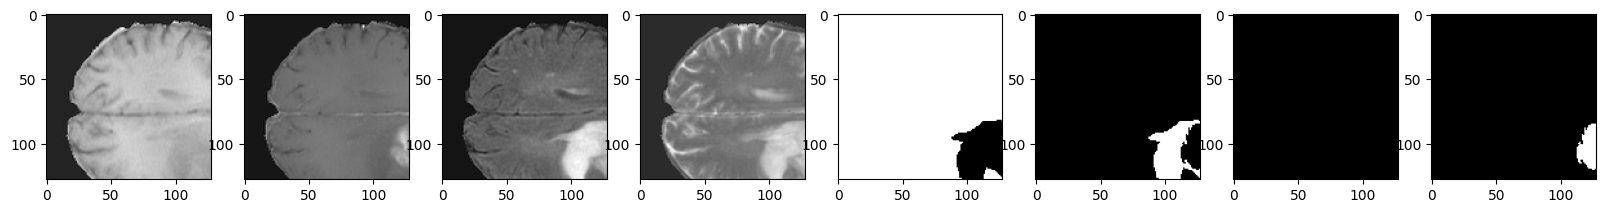

In [7]:

f, axarr = plt.subplots(1,8,figsize = (20,25))
i = 100 #random.randint(0,127) 
b = 0
axarr[0].imshow(X[b,:,:,i,0], cmap='gray')
axarr[1].imshow(X[b,:,:,i,1], cmap='gray')
axarr[2].imshow(X[b,:,:,i,2], cmap='gray')
axarr[3].imshow(X[b,:,:,i,3], cmap='gray')
axarr[4].imshow(y[b,:,:,i,0], cmap='gray')
axarr[5].imshow(y[b,:,:,i,1], cmap='gray')
axarr[6].imshow(y[b,:,:,i,2], cmap='gray')
axarr[7].imshow(y[b,:,:,i,3], cmap='gray')




['BRATS_01014_patch_0_0_1.pkl', 'BRATS_00650_patch_0_1_1.pkl'] 
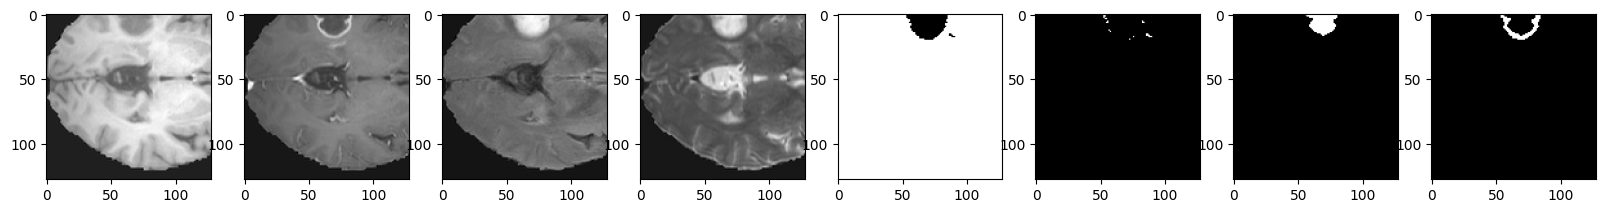

In [29]:
np.unique(y[1,:,:,:,:])

array([0., 1.], dtype=float32)

# Building and tuning the model

## Defining custom learning rate scheduler, loss function and build model function

In [5]:
def sum_dice_ce(y_true, y_pred, smooth=1.0, dc_ratio = 1):
    class_num = num_classes
    ## scale predictions so that the class probas of each sample sum to 1
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    ## clip to prevent NaN's and Inf's
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    for i in range(class_num):
        y_true_f = K.flatten(y_true[...,i])
        y_pred_f = K.flatten(y_pred[...,i])
        intersection = K.sum(y_true_f * y_pred_f)

        dice_loss = - K.log((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)+ K.epsilon())
        if i == 0:
            total_dice_loss = dice_loss 
        else:
            total_dice_loss = total_dice_loss + dice_loss 

            
    total_dice_loss = total_dice_loss / class_num
    ce_loss = y_true * K.log(y_pred)
    ce_loss = -K.sum(ce_loss, -1)
    total_loss = (ce_loss + dc_ratio*total_dice_loss)/(1+dc_ratio) 
    return total_loss

lossfunct = partial(sum_dice_ce, smooth = 1e-6) #new function made with fixed weights
lossfunct.__name__ ='sum_dice_ce'

class CustomLearningRateScheduler(Callback):
    def __init__(self,patience=5, factor=0.1, min_lr=1e-7):
        super(CustomLearningRateScheduler, self).__init__()
        self.patience = patience  # Number of epochs to wait before reducing LR
        self.factor = factor      # Factor to reduce the learning rate by (e.g., 0.1 for reducing by 10x)
        self.best_loss = float('inf')
        self.wait = 0
        self.min_lr = min_lr  # Minimum learning rate to avoid it going too low

    def on_train_begin(self, logs=None):
        """
        Store the initial learning rate at the beginning of training.
        """
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return
        
        # Check if the loss improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0  # Reset the wait counter since there's improvement
        else:
            self.wait += 1  # Increment the wait counter if there's no improvement

        # If no improvement in 'self.patience' epochs, reduce the learning rate
        if self.wait >= self.patience:
            current_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            new_lr = current_lr * self.factor

            # Ensure that the new learning rate is not lower than the minimum allowed
            if new_lr < self.min_lr:
                new_lr = self.min_lr
            # Reduce the learning rate
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            
            # Delay printing the message until after Keras prints the training output
            sys.stdout.write(f"\nEpoch {epoch + 1}: Reducing learning rate to {new_lr}\n")
            sys.stdout.flush()
            self.wait = 0  # Reset the wait counter after reducing the LR

    def reset(self):
        """Reset the internal state after each PSO trial."""
        self.best_loss = float('inf')
        self.wait = 0
        """Ensure the learning rate is reset to the initial value at the start of training."""
        tf.keras.backend.set_value(self.model.optimizer.lr, self.initial_lr)
        print(f"Learning rate reset to {self.initial_lr}, it is now {self.model.optimizer.lr.numpy()}")


## Defining the callbacks
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = CustomLearningRateScheduler(patience=5)

# Create a custom Model

def build_Unet_mealpy(hp):
    
    filters = [16] + hp[:3] #filters 0 +filters 1-3
    filter_btl = hp[3]
    dropout_rates = [0.1] + hp[4:7]
    dropout_btl = hp[7]
    downsample_method = hp[8:12]
    dc_ratio = hp[12]  # Tune the dice-cce ratio
    K.clear_session()
    gc.collect()
    num_layers = 4  # Define how many layers you want
    inputs = tf.keras.Input(shape=(128, 128, 128, 4))  # Adjust based on your input shape

    # Encoder
    x = inputs
    
    skips = []
    

    for i in range(num_layers):
        dropout_rate = dropout_rates[i]  # Tune dropout rate
        filter_ = filters[i]

        xr = tf.keras.layers.Conv3D(
            filters = filter_, kernel_size = (3,3,3),strides = (1,1,1), padding='same')(x) 
        x = tfa.layers.InstanceNormalization()(xr)
        x = tf.keras.layers.Dropout(dropout_rate, noise_shape=None, seed=0)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        
        x = tf.keras.layers.Conv3D(
            filters = filter_, kernel_size = (3,3,3),strides = (1,1,1), padding='same')(x) 
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate, noise_shape=None, seed=0)(x)
        x = tf.keras.layers.LeakyReLU()(x)
        x = tf.keras.layers.Add()([x,xr])
        skips.append(x)  # Store for skip connection

        if downsample_method[i] == 'maxpool':
            x = tf.keras.layers.MaxPool3D((2, 2, 2))(x)
        else:
            x = tf.keras.layers.Conv3D(
            filters = filter_, kernel_size = (3,3,3),strides = (2,2,2), padding='same')(x) 
            x = tf.keras.layers.LeakyReLU()(x)


    # Bottleneck  
    xr = tf.keras.layers.Conv3D(
        filters = filter_btl, kernel_size = (3,3,3),strides = (1,1,1), padding='same')(x) 
    x = tfa.layers.InstanceNormalization()(xr)
    x = tf.keras.layers.Dropout(dropout_btl, noise_shape=None, seed=0)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    
    x = tf.keras.layers.Conv3D(
        filters = filter_btl, kernel_size = (3,3,3),strides = (1,1,1), padding='same')(x)
    x = tfa.layers.InstanceNormalization()(x)
    x = tf.keras.layers.Dropout(dropout_btl, noise_shape=None, seed=0)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Add()([x,xr])
    

    # Decoder
    for i in reversed(range(num_layers)):
        
        skip_connection = skips[i]  # Get the corresponding encoder block output
        dropout_rate = dropout_rates[i]  # Tune dropout rate
        filter_ = filters[i]

        x = tf.keras.layers.Conv3DTranspose(
            filters = filter_, kernel_size = (3,3,3),strides = (2,2,2), padding='same')(x) 
        x = tf.keras.layers.Concatenate()([x, skip_connection])  # Concatenate
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate, noise_shape=None, seed=0)(x)
        x = tf.keras.layers.LeakyReLU()(x)

        x = tf.keras.layers.Conv3D(
            filters = filter_, kernel_size = (3,3,3),strides = (1,1,1), padding='same')(x) 
        x = tfa.layers.InstanceNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate, noise_shape=None, seed=0)(x)
        x = tf.keras.layers.LeakyReLU()(x)

    # Output layer for 4 channels (one for each class) and softmax activation
    outputs = tf.keras.layers.Conv3D(4, (1, 1, 1), activation='softmax')(x)
    # x = tf.keras.layers.Conv3D(
    #     4, (3,3,3),(1,1,1), padding='valid')(x) 
    # #print('x dtype: %s' % x.dtype.name)
    # outputs = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
    # #print('Outputs dtype: %s' % outputs.dtype.name)

    # Define the model
    model = tf.keras.Model(inputs, outputs)

    # Compile the model with the custom loss function
    
    lossfunct = partial(sum_dice_ce, smooth=1e-6, dc_ratio=dc_ratio)  # New function made with variable dc_ratio
    lossfunct.__name__ = 'sum_dice_ce'

    # Compile the model with categorical_crossentropy since the labels are one-hot encoded
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss=lossfunct, metrics=[f1_score_3ch])

    # Check and print the current hyperparameters
    #print("Current hyperparameters: ", model.count_params())

    return model
        


In [6]:
modelname = 'orignalpso_181024'
#tb_log = keras.callbacks.TensorBoard(f"./{modelname}/tblogs")
#stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = CustomLearningRateScheduler(patience=5)
epochs = 15
max_params_threshold = 9408807
def gen_filt_list(lb,ub,inc = 8):
  return list(range(lb, ub + 1, inc))

hyperparameter_choices = [
    gen_filt_list(32,48),  # First hyperparameter (e.g., number of filters in the first layer)
    gen_filt_list(64,144),  # Second hyperparameter
    gen_filt_list(128,288,16),  # Third hyperparameter
    gen_filt_list(258,384,16),  # Fourth hyperparameter
    [0.1,0.3,0.5],
    [0.1,0.3,0.5],
    [0.1,0.3,0.5],
    [0.1,0.3,0.5],
    ['maxpool','conv'],
    ['maxpool','conv'],
    ['maxpool','conv'],
    ['maxpool','conv'],
    [2, 1.5,1,0.75,0.5],
]

bounds = MixedSetVar(valid_sets=hyperparameter_choices)

## Define the objective function for PSO
def evaluate_particle(particle):

    decoded_solution = bounds.decode(particle)
    print(decoded_solution)
    model = build_Unet_mealpy(decoded_solution)

    if model.count_params() > max_params_threshold:
        print(f"Model has {model.count_params()} parameters, exceeding the threshold of {max_params_threshold}.")
        # Return negative infinity as penalty and skip training
        del(model,decoded_solution)
        K.clear_session()
        gc.collect()
        cuda.select_device(0)
        cuda.close()
        return -float('inf')
    
    
    print(f"Model has {model.count_params()} parameters.")
    #print('main code branch')
    history = model.fit(
        train_data,
        steps_per_epoch=steps_per_epoch, # steps per epoch
        epochs=epochs,
        validation_data= val_data,
        validation_steps=val_steps_per_epoch,
        callbacks=[lr_scheduler]) #,tb_log

    trial_metric = history.history['val_f1_score_3ch'][-1]
    lr_scheduler.reset()
    del(model,history,decoded_solution)
    K.clear_session()
    gc.collect()
    cuda.select_device(0)
    cuda.close()
    # Save best model to avoid refitting, change the rule accordingly
    return trial_metric

# Define the problem dictionary for mealpy's PSO
problem_dict = {
    "obj_func": evaluate_particle,  # Use the objective function defined above
    "bounds": bounds,  # Hyperparameter bounds
    "minmax": "max",   # Maximize the sum of squares
    #"log_to": "file",  # Optionally log results to a file
    #"log_file": f"{modelname}_results.txt",
    "save_population": False,  
}

# Initialize and run PSO
model = PSO.OriginalPSO(epoch=10, pop_size=10, c1=2.05, c2=2.05, w=0.4)
g_best = model.solve(problem_dict,seed=0)

# Print the best solution and its corresponding fitness value
print(f"Best Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Best Decoded Solution: {bounds.decode(g_best.solution)}, Fitness: {g_best.target.fitness}")

[48, 120, 208, 290, 0.1, 0.1, 0.1, 0.1, 'maxpool', 'conv', 'conv', 'conv', 1]


2024/10/18 09:32:16 AM, INFO, mealpy.swarm_based.PSO.OriginalPSO: Solving single objective optimization problem.


Model has 13735012 parameters, exceeding the threshold of 9408807.
[40, 144, 256, 338, 0.3, 0.3, 0.5, 0.1, 'conv', 'conv', 'maxpool', 'maxpool', 0.5]
Model has 17292100 parameters, exceeding the threshold of 9408807.
[40, 64, 256, 338, 0.5, 0.1, 0.1, 0.5, 'maxpool', 'conv', 'maxpool', 'maxpool', 1]
Model has 14657492 parameters, exceeding the threshold of 9408807.
[40, 96, 128, 258, 0.1, 0.1, 0.5, 0.3, 'conv', 'maxpool', 'conv', 'conv', 1.5]
Model has 7415548 parameters.
Epoch 1/15


ResourceExhaustedError: Graph execution error:

Detected at node 'model/dropout/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_15892\2732023149.py", line 76, in <module>
      g_best = model.solve(problem_dict,seed=0)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 229, in solve
      self.initialization()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 135, in initialization
      self.pop = self.generate_population(self.pop_size)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 332, in generate_population
      pop = [self.generate_agent() for _ in range(0, pop_size)]
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 332, in <listcomp>
      pop = [self.generate_agent() for _ in range(0, pop_size)]
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\swarm_based\PSO.py", line 78, in generate_agent
      agent.target = self.get_target(agent.solution)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 406, in get_target
      return self.problem.get_target(solution)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\utils\problem.py", line 200, in get_target
      objs = self.obj_func(solution)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_15892\2732023149.py", line 48, in evaluate_particle
      history = model.fit(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model/dropout/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[2,128,128,128,16] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/dropout/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_16560]

### Performing the tuning

15216004 too much, 6m fine, 11m too much, 9m fine, 9.6m too much,9.3m fine, 9.4 is fine but about the limit

In [5]:
# Define the problem dictionary for mealpy's PSO
problem_dict = {
    "obj_func": evaluate_particle,  # Use the objective function defined above
    "bounds": bounds,  # Hyperparameter bounds
    "minmax": "max",   # Maximize the sum of squares
    "log_to": "file",  # Optionally log results to a file
    "log_file": f"{modelname}_results.txt",
    "save_population": False,  
}

# Initialize and run PSO
model = PSO.AIW_PSO(epoch=10, pop_size=10, c1=2.05, c2=2.05, alpha=0.4)
g_best = model.solve(problem_dict)

# Print the best solution and its corresponding fitness value
print(f"Best Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")
print(f"Best Decoded Solution: {bounds.decode(g_best.solution)}, Fitness: {g_best.target.fitness}")

[48, 136, 224, 370, 0.5, 0.5, 0.1, 0.3, 'maxpool', 'conv', 'maxpool', 'conv', 1.5]
Model has 17407836 parameters, exceeding the threshold of 9408807.
[40, 144, 256, 322, 0.1, 0.5, 0.3, 0.5, 'conv', 'maxpool', 'maxpool', 'conv', 2]
Model has 18512188 parameters, exceeding the threshold of 9408807.
[32, 88, 288, 274, 0.3, 0.1, 0.3, 0.1, 'conv', 'conv', 'conv', 'maxpool', 2]
Model has 15539156 parameters, exceeding the threshold of 9408807.
[40, 144, 176, 354, 0.5, 0.5, 0.1, 0.3, 'conv', 'conv', 'conv', 'maxpool', 1]
Model has 13420500 parameters, exceeding the threshold of 9408807.
[40, 64, 176, 338, 0.1, 0.5, 0.5, 0.3, 'maxpool', 'conv', 'conv', 'maxpool', 0.75]
Model has 10231028 parameters, exceeding the threshold of 9408807.
[32, 72, 288, 354, 0.3, 0.1, 0.5, 0.5, 'maxpool', 'conv', 'maxpool', 'conv', 1.5]
Model has 19679884 parameters, exceeding the threshold of 9408807.
[40, 112, 224, 258, 0.3, 0.3, 0.3, 0.3, 'conv', 'conv', 'conv', 'maxpool', 0.5]
Model has 12177684 parameters, exc

UnknownError: Graph execution error:

Detected at node 'gradient_tape/model/conv3d_16/Conv3D/Conv3DBackpropFilterV2' defined at (most recent call last):
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_9452\888349666.py", line 13, in <module>
      g_best = model.solve(problem_dict)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 237, in solve
      self.evolve(epoch)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\swarm_based\PSO.py", line 203, in evolve
      target = self.get_target(pos_new)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\optimizer.py", line 406, in get_target
      return self.problem.get_target(solution)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\mealpy\utils\problem.py", line 200, in get_target
      objs = self.obj_func(solution)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_9452\1733130970.py", line 46, in evaluate_particle
      history = model.fit(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/conv3d_16/Conv3D/Conv3DBackpropFilterV2'
CUDNN failed to allocate the scratch space for the runner or to find a working no-scratch runner.
	 [[{{node gradient_tape/model/conv3d_16/Conv3D/Conv3DBackpropFilterV2}}]] [Op:__inference_train_function_76332]

In [ ]:
## Save model to file
io.save_model(model, "./model.pkl")



# Training model

In [7]:
# Load the hyperparameters from the JSON file
## Load the model from file
optimizer = io.load_model("./model.pkl")
optimal_hp = bounds.decode(optimizer.g_best.solution)
print(f"Best solution: {optimal_hp}, Best fitness: {optimizer.g_best.target.fitness}")

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = build_Unet_mealpy(optimal_hp)

model.metrics_names
model.summary()

In [ ]:
save_weights = ModelCheckpoint(filepath=f'{modeldir}//{modelname}', 
                             monitor='val_f1_score_3ch',
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
history = model.fit(train_data,
        steps_per_epoch=steps_per_epoch, # steps per epoch
        epochs=60,
        verbose = 1,
        validation_data= val_data,
        validation_steps=val_steps_per_epoch,
        callbacks=[lr_scheduler,tb_log,save_weights]) #

In [ ]:
history.history
val_acc_per_epoch = history.history['val_f1_score_3ch']

best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

import pickle
with open(f'{modeldir}{modelname}history_hyperband_1epochs.pkl', 'wb') as f:
    pickle.dump(history.history, f) 

## Sanity checks

In [22]:
import pickle
# Assuming modeldir and modelname are defined
with open(f'{modeldir}{modelname}history_hyperband_1epochs.pkl', 'rb') as f:
    test = pickle.load(f)

In [9]:
# The model weights (that are considered the best) can be loaded as -
model.load_weights(modeldir)

history = model.fit(train_data,
        steps_per_epoch=steps_per_epoch, # steps per epoch
        epochs=60,
        verbose = 1,
        validation_data= val_data,
        validation_steps=val_steps_per_epoch) #